# Construct single qubit quantum gates

A quantum circuit is a powerful representation of an algorithm specifically designed to be executed on a gated-based universal quantum processor. While the usual way to define a circuit is using common gates, gates however abstract the underlying details of how qubits operate. 

A simple example of pulse-level control is using a parametric gate like $R_X$. An $R_X(θ)$ gate rotates the quantum state of a qubit by an angle θ with respect to an X axis defined by some properties of the pulse sequence. While this is equivalent to applying a pulse of a certain duration on a specific frame used to drive the qubit, it is not the most convenient implementation of the $R_X$ gate as it requires to calibrate and carefully map between the pulse duration and the angle.

In this tutorial, we will describe how a method to create any single-qubit gate with pulses, based on a decomposition to a product of $R_X(\pi/2)$ and $R_Z$ gates.

Let's first import some packages.

In [1]:
%matplotlib inline

from braket.aws import AwsDevice
from braket.pulse import PulseSequence, GaussianWaveform, ConstantWaveform, DragGaussianWaveform
from braket.parametric import FreeParameter
from braket.circuits import Circuit, circuit

## Imports for function fitting
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.fft import fft, fftfreq

While we use Rigetti's Aspen M-2 device here, this notebooks can be easily adapted to OQC's Lucy device by changing the parameters of the $\pi$/2 pulse. 

In [2]:
device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2")

We use qubit #4 and define a couple of frame to drive and readout the qubit

In [3]:
qubit = 4
drive_frame = device.frames["q4_rf_frame"]
readout_frame = device.frames["q4_ro_rx_frame"]

## Calibrating $\pi$/2 pulses via Rabi spectroscopy 

As single-qubit gates are rotations around the Bloch sphere, we can get the intuition that any of them can be decomposed as a series of rotations around the X axis and the Z axis. Here, Z is defined as the axis along the measurement basis and X by the direction of the driving field with a phase equals to 0. We formalize the decomposition in more details below where we will see that it is only necessary to calibrate a single operation per qubit, namely a $\pi$/2 pulse, to build any single-qubit gate.

Let's optimize the pulse power to realize a $\pi$/2 pulse. First we write the short sequence that will drive the qubit with a single pulse around the X axis (since the phase is set to 0). Unlike in the [tutorial](./1_Bringup_experiments.ipynb) where we presented a $\pi/2$-pulse calibration based on a length sweep, here we will keep the pulse length fixed to 40ns and its width to 5ns and find the best pulse amplitude.

In [4]:
width = 5e-9
length = 40e-9
waveform = GaussianWaveform(length, width, FreeParameter("amplitude"), False)

rabi_sequence = ( 
    PulseSequence()
    .play(drive_frame, waveform)
    .capture_v0(readout_frame)
)

We create the sweep range and execute the batch of pulse sequences

In [5]:
start_amp=0.01
end_amp=0.75
amps = np.arange(start_amp, end_amp, 0.02)
N_shots = 1000

pulse_sequences = [rabi_sequence(amplitude=amplitude) for amplitude in amps]

batch = device.run_batch(pulse_sequences, shots=N_shots)

We define a fit function that is the product of an exponential and a sine function as we expect the qubit to oscillate between the state $|0\rangle$ and the state $|1\rangle$. The projected state after measurement must display this oscillatory dynamics.

rx(pi/2) amplitude:  0.16189  ns


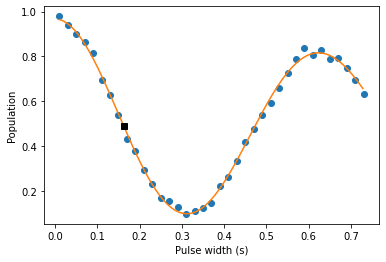

In [6]:
def damped_oscillation_fit(x, A, A0, Tau, f, x0):
    return A*np.exp(-x/Tau)*np.cos(2*np.pi*(x-x0)*f)+A0

population = [result.measurement_counts['0']/N_shots for result in batch.results()]
x, y = amps, population

initial_guess=[0.5, 0.5, 1, 0.4, 0]
optimal_params, _ = scipy.optimize.curve_fit(damped_oscillation_fit, x, y, p0=initial_guess)
x_fit = np.arange(x[0],x[-1], np.diff(x)[0]/10)
y_fit = damped_oscillation_fit(x_fit, *optimal_params)

plt.plot(x,y, 'o')
plt.plot(x_fit,y_fit)
plt.xlabel("Pulse width (s)")
plt.ylabel("Population")

frequency = optimal_params[3]
phase_offset = optimal_params[4]
x90_amplitude=(np.pi/2)/(2*np.pi*frequency)+phase_offset
plt.plot(x90_amplitude, damped_oscillation_fit(x90_amplitude, *optimal_params), 'ks')

print('rx(pi/2) amplitude: ', round(x90_amplitude, 5), ' ns')



We save the $\pi$/2 calibration to reuse it later.

In [7]:
x90 = GaussianWaveform(length, width, x90_amplitude, False)

## Canonical decomposition of single-qubit gates
Native gates are directly related to the Hamiltonian of the qubits and do not require a complex design. Their implementation could essentially rely on the application of a single pulse. An example of a native gate is the $R_X(π/2)$ gate, also known as the V or SX gate (equivalent up to a global phase $e^{-i\pi/4}$) that we just calibrated. 

On the other hand, non-native gates cannot be directly understood from a continuous Hamiltonian and usually requires a sequence of pulses with varying parameters. The concept of native gates is rather loose and gates that could be designed with a single pulse such as the Hadamard gate are often decomposed into a series of native gates during the compilation stage. 

As the state of a single qubit can be represented as a vector on the Bloch sphere, any gate operated on this qubit can be expressed via the following unitary matrix:

$$
  U(θ,ϕ,λ) = 
  \begin{pmatrix}
    \cos⁡(\theta/2) & -ie^{iλ} sin⁡(θ/2)\\
    -ie^{iϕ} \sin⁡(θ/2) & e^{i(ϕ+λ)} \cos⁡(θ/2)
  \end{pmatrix}
$$

It is then convenient to decompose any 1-qubit gate (including the $R_X(\theta)$ gate) into a sequence of three $R_Z$ gates, which will be [absorbed](https://aip.scitation.org/doi/10.1063/1.5089550) into an instantaneous and perfect shift of the phase of the frame, and two $R_X$ gates with a fixed angle of π/2. The result is that 1-qubit gates have all the same θ-independent duration (up to a global phase):

$$U(θ,ϕ,λ)= R_Z (ϕ- π/2) R_X (π/2) R_Z (π-θ) R_X (π/2) R_Z (λ- π/2)$$

We implement the parametric sequence by composing a sequence with `shift_phase` and `play` instructions


In [8]:
lambda_ = FreeParameter("lambda_")
theta = FreeParameter("theta")
phi = FreeParameter("phi")

U_sequence = (
    PulseSequence()
    .shift_phase(drive_frame, lambda_ - np.pi/2)
    .play(drive_frame, x90)
    .shift_phase(drive_frame, np.pi - theta)
    .play(drive_frame, x90)
    .shift_phase(drive_frame, phi - np.pi/2)
)

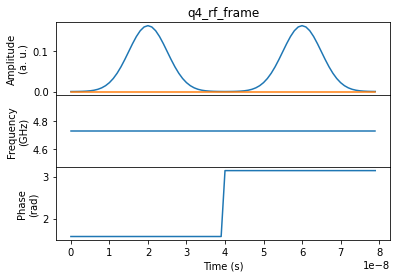

In [9]:
data = U_sequence(theta=np.pi/2, phi=0, lambda_=np.pi).to_time_trace()
for frame_id in data.amplitudes:
    f, ax = plt.subplots(nrows=3, sharex=True)
    f.subplots_adjust(hspace=0)

    ax[0].set_title(frame_id)
    ax[0].plot(data.amplitudes[frame_id].times(), np.real(data.amplitudes[frame_id].values()), label="Real")
    ax[0].plot(data.amplitudes[frame_id].times(), np.imag(data.amplitudes[frame_id].values()), label="Imag")
    ax[0].set_ylabel("Amplitude\n(a. u.)")
    ax[0].tick_params('x', labelbottom=False)

    ax[1].plot(data.frequencies[frame_id].times(), np.array(data.frequencies[frame_id].values())*1e-9)
    ax[1].set_ylabel("Frequency\n(GHz)")
    ax[1].tick_params('x', labelbottom=False)

    ax[2].plot(data.phases[frame_id].times(), data.phases[frame_id].values())
    ax[2].set_xlabel("Time (s)")
    ax[2].set_ylabel("Phase\n(rad)")

With this sequence, we can create the U Gate via the `pulse_gate` function. For instance, the Hadamard gate is implemented by:
  
$$ U(π/2,0,π)=R_Z (-π/2) R_X (π/2) R_Z (π/2) R_X (π/2) R_Z (π/2) $$

In the following, we test our implementation of the U gate by probing its behavior when we sweep the angle $\theta$ fixing $\phi$ and $\lambda$ to zero. We expect to achieve the $R_X$ gate that makes the qubit oscillate between $|0\rangle$ and $|1\rangle$ around the X axis. We initialize the state along both the X and Y axis before applying the U gate, to confirm that the $R_X$ gate was created successfully. If we initialize the qubit along the X axis which should coincide with the rotation X, we should observe a flat line as the qubit remains in the same state. 

In [10]:
@circuit.subroutine(register=True)
def U_pulses(theta, phi, lambda_):
    return (
        Circuit()
        .pulse_gate(
            [qubit], 
            pulse_sequence=U_sequence(theta=theta, phi=phi, lambda_=lambda_)
        )
    )

In [11]:
nb_shots=500
thetas=np.linspace(0, 2*np.pi, 25)

# initialization along the X axis
b_X=device.run_batch([Circuit().rx(4, np.pi/2).rz(4, np.pi/2).U_pulses(t, 0, 0) for t in thetas], shots=nb_shots, disable_qubit_rewiring=True)

# initialization along the Y axis
b_Y=device.run_batch([Circuit().rx(4, np.pi/2).U_pulses(t, 0, 0) for t in thetas], shots=nb_shots, disable_qubit_rewiring=True)

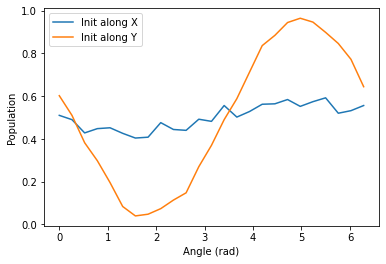

In [12]:
population_init_X = [result.measurement_counts['0']/nb_shots for result in b_X.results()]
plt.plot(thetas, population_init_X, label="Init along X")

population_init_Y = [result.measurement_counts['0']/nb_shots for result in b_Y.results()]
plt.plot(thetas, population_init_Y, label="Init along Y")

plt.xlabel("Angle (rad)")
plt.ylabel("Population")
plt.legend()

We observe that applying $U(\theta, 0, 0)$ after initializing the qubit along the X axis does not seem to change the qubit state. On the other hand, the qubit undergoes a rotation of period $2\pi$ if initialized on the Y axis. This indicates that we have construct an $R_X$ gate.

The fidelity of the gate is noticibly low. This is mainly due to the $\pi/2$ pulse characterization that is too simplistic. To go further, we could switch to DragGaussianWaveform that suppresses excitations in the second excited state during driving and implement a better calibration scheme that would optimize the detuning, phase and length of pulse and limit the impact of SPAM errors.

## Construct a Hadamard gate with a single pulse
A trade-off to the previous construct is that any gate will have the same duration, i.e., the duration equivalent to a π-equivalent which is longest optimal duration for a 1-qubit gate. If you were able to use a single π/2-pulse, you would theoretically improve your gate duration and fidelity. In particular, let’s see that this decomposition is not the most performant for the Hadamard gate.

The Hadamard gate is describable by a single rotation using the $U_2$  decomposition. 

$$ U(π/2,ϕ,λ)=U_2 (ϕ,λ)=R_Z (ϕ+π/2) R_X (π/2) R_Z (λ-π/2) $$

Identifying that the Hadamard gate is given by $U_2(0, \pi)$, we can write a sequence directly from this decomposition as the following pulse sequence:

In [13]:
single_x90_sequence = ( 
    PulseSequence()
    .shift_phase(drive_frame, lambda_ - np.pi/2)
    .play(drive_frame, x90)
    .shift_phase(drive_frame, phi + np.pi/2)
)

We can visualize that we have only a single pulse.

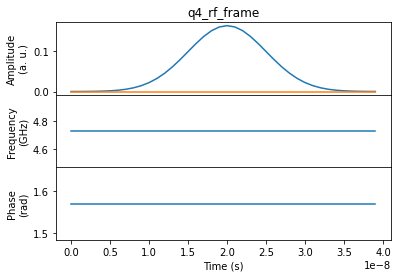

In [14]:
data = single_x90_sequence(phi=0, lambda_=np.pi).to_time_trace()
for frame_id in data.amplitudes:
    f, ax = plt.subplots(nrows=3, sharex=True)
    f.subplots_adjust(hspace=0)

    ax[0].set_title(frame_id)
    ax[0].plot(data.amplitudes[frame_id].times(), np.real(data.amplitudes[frame_id].values()), label="Real")
    ax[0].plot(data.amplitudes[frame_id].times(), np.imag(data.amplitudes[frame_id].values()), label="Imag")
    ax[0].set_ylabel("Amplitude\n(a. u.)")
    ax[0].tick_params('x', labelbottom=False)

    ax[1].plot(data.frequencies[frame_id].times(), np.array(data.frequencies[frame_id].values())*1e-9)
    ax[1].set_ylabel("Frequency\n(GHz)")
    ax[1].tick_params('x', labelbottom=False)

    ax[2].plot(data.phases[frame_id].times(), data.phases[frame_id].values())
    ax[2].set_xlabel("Time (s)")
    ax[2].set_ylabel("Phase\n(rad)")

You can register this gate with the subroutine decorated as follow. Executing the gate indicates that we have created an equal-weigth superposition of $|0\rangle$ and $|1\rangle$.

In [15]:
@circuit.subroutine(register=True)
def short_h_4():
    return (
        Circuit()
        .pulse_gate(
            [qubit], 
            pulse_sequence=single_x90_sequence(phi=0, lambda_=np.pi)
        )
    )

circ = Circuit().short_h_4()
print(device.run(circ, shots=1000).result().measurement_counts)

Counter({'0': 515, '1': 485})
